In [53]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

###### Choose a grayscale image with a maximum value (intensity) M - this value is used in the definition of the below PSNR

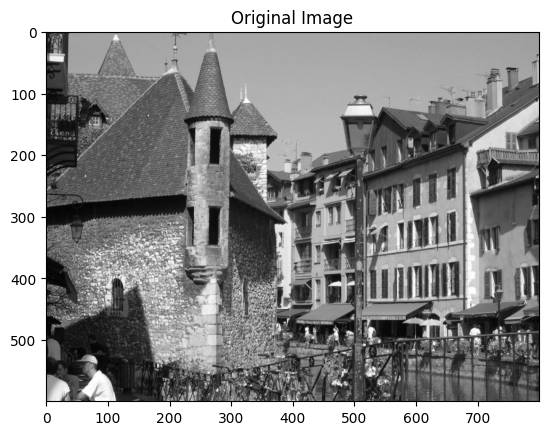

In [54]:
img = cv2.imread('4.JPG', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

###### Apply the DWT (multiresolution analysis with the Haar Wavelet) on 1 level

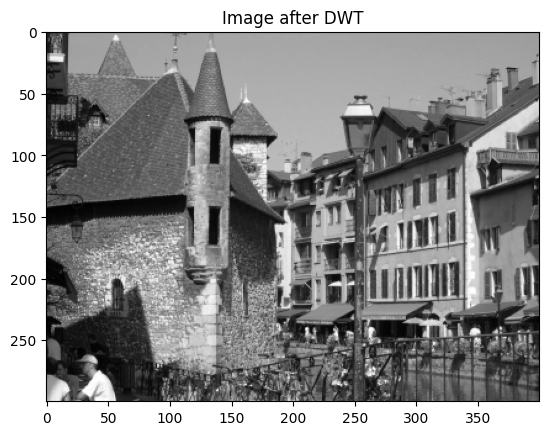

In [68]:
def apply_dwt(image, wavelet='haar', level=1):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    return coeffs

coeffs = apply_dwt(img)
cA, (cH, cV, cD) = coeffs
plt.imshow(cA, cmap='gray')
plt.title('Image after DWT')
plt.show()

###### Apply a threshold T

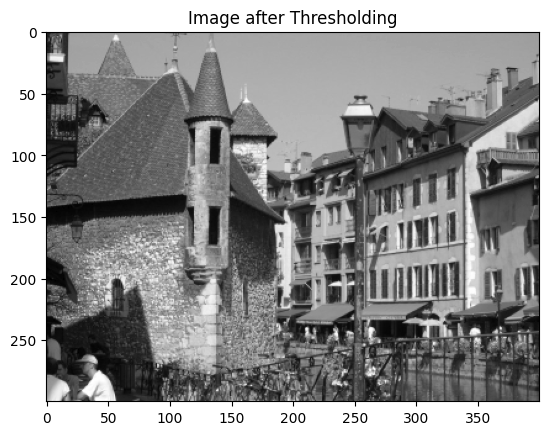

In [69]:
def apply_threshold(coeffs, threshold):
    cA, (cH, cV, cD) = coeffs
    return (cA * (abs(cA) > threshold), 
            (cH * (abs(cH) > threshold), 
             cV * (abs(cV) > threshold), 
             cD * (abs(cD) > threshold)))

coeffs = apply_dwt(img)
thresholded_coeffs = apply_threshold(coeffs, threshold)

cA, (cH, cV, cD) = thresholded_coeffs
plt.imshow(cA, cmap='gray')
plt.title('Image after Thresholding')
plt.show()

###### Compute the PSNR (reference image = orignal image) of the reconstruction (DWT-1)

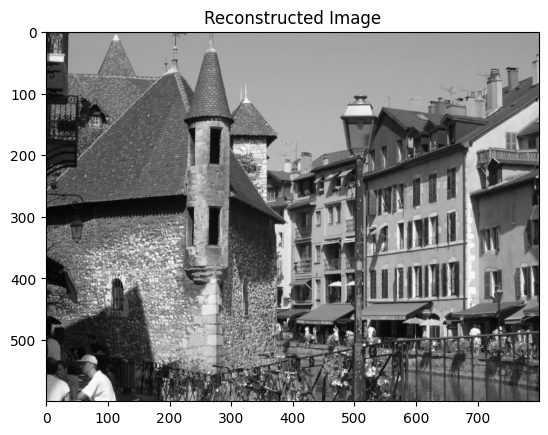

In [70]:
def compute_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

reconstructed = pywt.idwt2(thresholded_coeffs, 'haar')
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

###### Plot PSNR = fct(T)

In [71]:
def plot_psnr(psnr_vals, thresholds):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, psnr_vals)
    plt.title('PSNR as a function of Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('PSNR')
    plt.grid()
    plt.show()

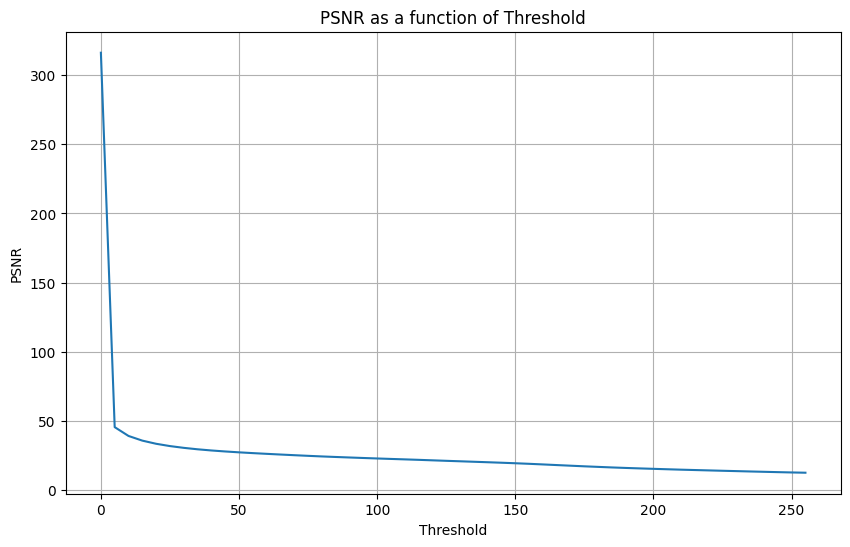

In [72]:
def apply_threshold(coeffs, threshold):
    cA, (cH, cV, cD) = coeffs
    return (cA * (abs(cA) > threshold), 
            (cH * (abs(cH) > threshold), 
             cV * (abs(cV) > threshold), 
             cD * (abs(cD) > threshold)))

thresholds = list(range(0, 256, 5))
psnr_vals = []

for t in thresholds:
    thresholded_coeffs = apply_threshold(coeffs, t)
    reconstructed = pywt.idwt2(thresholded_coeffs, 'haar')
    psnr_vals.append(compute_psnr(img, reconstructed))

plot_psnr(psnr_vals, thresholds)


###### Repeat the process with the noisy image (add a Gaussian White Noise, noise level-> standard deviation D)

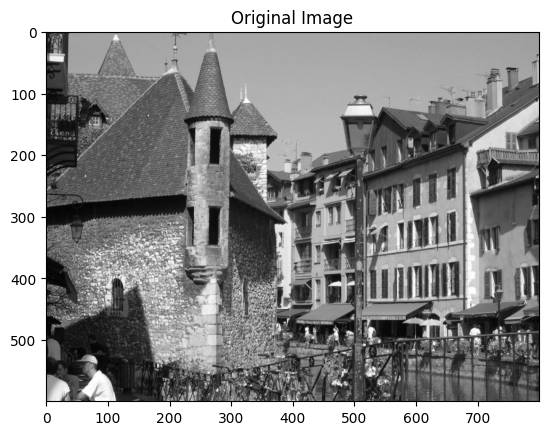

In [73]:
# Original image
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

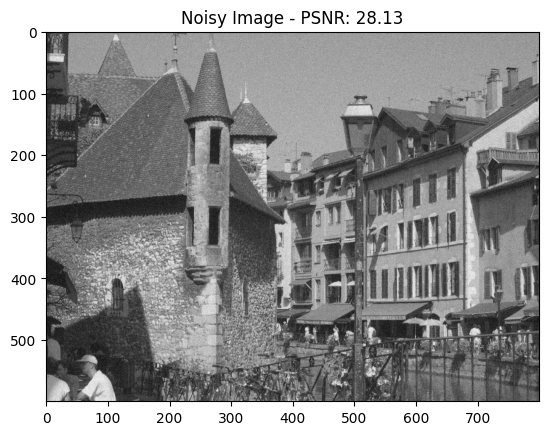

In [74]:
noise_std_dev = 10
noisy_img = img + np.random.normal(0, noise_std_dev, img.shape)
psnr_noisy = compute_psnr(img, noisy_img)
plt.imshow(noisy_img, cmap='gray')
plt.title(f'Noisy Image - PSNR: {psnr_noisy:.2f}')
plt.show()

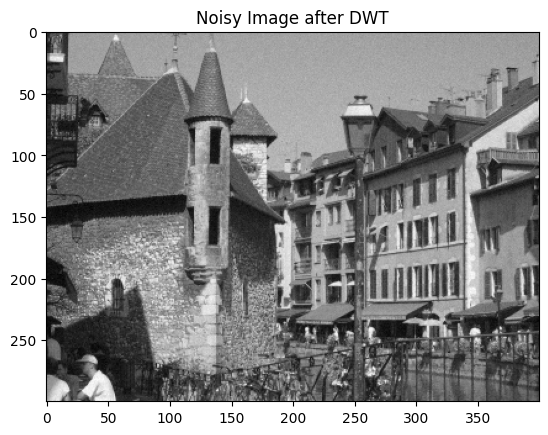

In [75]:
coeffs = apply_dwt(noisy_img)
cA, (cH, cV, cD) = coeffs
plt.imshow(cA, cmap='gray')
plt.title('Noisy Image after DWT')
plt.show()

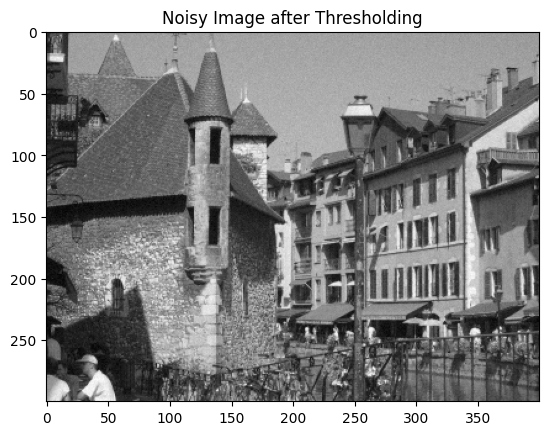

In [76]:
thresholded_coeffs = apply_threshold(coeffs, threshold)
cA, (cH, cV, cD) = thresholded_coeffs
plt.imshow(cA, cmap='gray')
plt.title('Noisy Image after Thresholding')
plt.show()

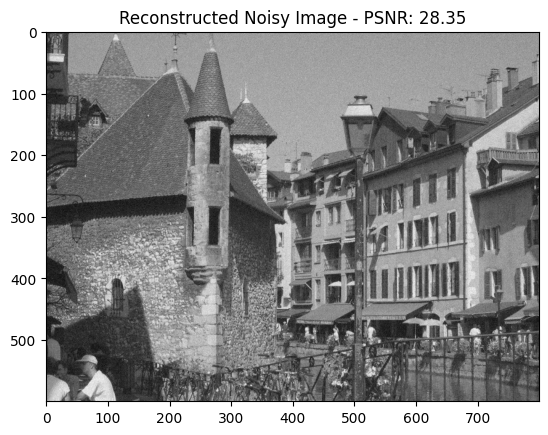

In [77]:
reconstructed = pywt.idwt2(thresholded_coeffs, 'haar')
psnr_reconstructed = compute_psnr(img, reconstructed)
plt.imshow(reconstructed, cmap='gray')
plt.title(f'Reconstructed Noisy Image - PSNR: {psnr_reconstructed:.2f}')
plt.show()

###### Find the optimal threshold To for denoising (PSNR). Note the reference image is the noise-free image

In [78]:
coeffs = apply_dwt(noisy_img)
psnr_vals = []

for t in thresholds:
    reconstructed = pywt.idwt2(apply_threshold(coeffs, t), 'haar')
    psnr_vals.append(compute_psnr(img, reconstructed))

optimal_threshold = thresholds[np.argmax(psnr_vals)]
print('Optimal Threshold:', optimal_threshold)

Optimal Threshold: 20


###### Study the evolution of To in respect of the noise level (D)

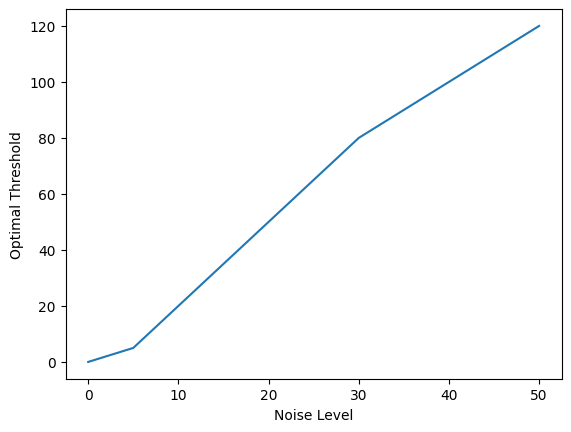

In [79]:
noise_levels = list(range(0, 51, 5))
optimal_thresholds = []

for noise_std_dev in noise_levels:
    noisy_img = img + np.random.normal(0, noise_std_dev, img.shape)
    coeffs = apply_dwt(noisy_img)
    psnr_vals = []

    for t in thresholds:
        reconstructed = pywt.idwt2(apply_threshold(coeffs, t), 'haar')
        psnr_vals.append(compute_psnr(img, reconstructed))

    optimal_threshold = thresholds[np.argmax(psnr_vals)]
    optimal_thresholds.append(optimal_threshold)

plt.plot(noise_levels, optimal_thresholds)
plt.xlabel('Noise Level')
plt.ylabel('Optimal Threshold')
plt.show()


###### Repeat all the process with two levels (L1 and L2) in the multiresolution analysis. Find the optimal thresholds T1 and T2. What is the relation between these T1 and T2 ?

In [81]:
def apply_threshold_levels(coeffs, threshold):
    thresholded_coeffs = [coeffs[0] * (abs(coeffs[0]) > threshold)]
    for detail in coeffs[1:]:
        thresholded_coeffs.append(tuple(d * (abs(d) > threshold) for d in detail))
    return thresholded_coeffs

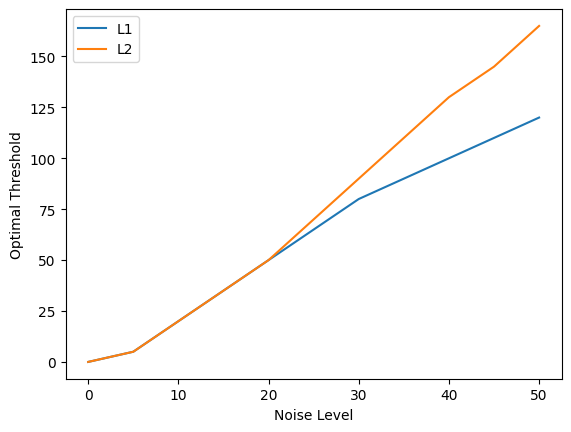

In [82]:
noise_levels = list(range(0, 51, 5))
optimal_thresholds_L1 = []
optimal_thresholds_L2 = []

for noise_std_dev in noise_levels:
    noisy_img = img + np.random.normal(0, noise_std_dev, img.shape)
    
    # Level 1
    coeffs_L1 = apply_dwt(noisy_img, level=1)
    psnr_vals_L1 = []
    for t in thresholds:
        reconstructed_L1 = pywt.idwt2(apply_threshold_levels(coeffs_L1, t), 'haar')
        psnr_vals_L1.append(compute_psnr(img, reconstructed_L1))
    optimal_threshold_L1 = thresholds[np.argmax(psnr_vals_L1)]
    optimal_thresholds_L1.append(optimal_threshold_L1)
    
    # Level 2
    coeffs_L2 = apply_dwt(noisy_img, level=2)
    psnr_vals_L2 = []
    for t in thresholds:
        reconstructed_L2 = pywt.waverec2(apply_threshold_levels(coeffs_L2, t), 'haar')
        psnr_vals_L2.append(compute_psnr(img, reconstructed_L2))
    optimal_threshold_L2 = thresholds[np.argmax(psnr_vals_L2)]
    optimal_thresholds_L2.append(optimal_threshold_L2)

plt.plot(noise_levels, optimal_thresholds_L1, label='L1')
plt.plot(noise_levels, optimal_thresholds_L2, label='L2')
plt.xlabel('Noise Level')
plt.ylabel('Optimal Threshold')
plt.legend()
plt.show()

In [84]:
optimal_thresholds_L1

[0, 5, 20, 35, 50, 65, 80, 90, 100, 110, 120]

In [85]:
optimal_thresholds_L2

[0, 5, 20, 35, 50, 70, 90, 110, 130, 145, 165]